In [1]:
import ipynb.fs.full.helper as h

from imp import reload
reload(h)

<module 'ipynb.fs.full.helper' (/tf/src/scripts/helper.ipynb)>

In [2]:
import cv2, os
import matplotlib.pyplot as plt
import numpy as np
from retinaface import RetinaFace
from tensorflow import keras
import ffmpeg

In [3]:
def image_detect(file_path):
    
    image = cv2.imread(file_path)
    
    pic = detect4_2(image)
    plt.imshow(cv2.cvtColor(pic, cv2.COLOR_RGB2BGR))
    plt.axis('off')
    plt.show()

    cv2.imwrite(file_out, pic)

In [4]:
def video_detect(file_path):    
    analyse(file_path, file_out)

In [5]:
def analyse(in_filename, out_filename):
    
    probe = ffmpeg.probe(in_filename)
    height = probe['streams'][0]['height']
    width = probe['streams'][0]['width']
    nb_frames = probe['streams'][0]['nb_frames']    
    
    process1 = (
    ffmpeg
    .input(in_filename)
    .output('pipe:', format='rawvideo', pix_fmt='rgb24', vframes=nb_frames)
    .run_async(pipe_stdout=True)
    )

    process2 = (
    ffmpeg
    .input('pipe:', format='rawvideo', pix_fmt='rgb24', s='{}x{}'.format(width, height))
    .output(out_filename, pix_fmt='yuv420p')
    .overwrite_output()
    .run_async(pipe_stdin=True)
    )

    while True:
        in_bytes = process1.stdout.read(width * height * 3)
        if not in_bytes:
            break
        in_frame = (
            np
            .frombuffer(in_bytes, np.uint8)
            .reshape([height, width, 3])
        )

        # Analyse
        out_frame = detect4_2(in_frame)

        process2.stdin.write(
            out_frame
            .astype(np.uint8)
            .tobytes()
        )

    process2.stdin.close()
    process1.wait()
    process2.wait()

In [6]:
def extract_face(face):
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

def get_label(frame,img_size):
    im = cv2.resize(frame,(img_size,img_size))
    im = np.array(im)/255.0
    im = im.reshape(1,img_size,img_size,3)
    result = model.predict(im)
    label_Y=1 if result>0.3 else 0
    return label_Y,result

In [7]:
assign = {'0':'Mask','1':"No Mask"}

def detect4_2(in_frame):

    try:
        image = in_frame
        resultIMG = in_frame

        faces = RetinaFace.detect_faces(image)
                
        for i in range(len(faces)):
            
            face = faces[f'face_{i+1}']['facial_area']
            confidence_threshold = faces[f'face_{i+1}']['score']
           
            (xmin,ymin,xmax,ymax) = face
            
            crop = image[ymin:ymax,xmin:xmax]

            # according to the confidence_threshold, to get the lable
            if confidence_threshold > 0.7:
                label_Y,result = get_label(crop,h.img_size)
                
                if (label_Y == 1):
                    crop = cv2.resize(crop,(224,224))
                    crop = np.reshape(crop,[1,224,224,3])/255.0
                    y_prob = classifier.predict(crop)
                    y_classes = y_prob.argmax(axis=-1)
                    prob = y_prob[0][y_classes][0]
                    
                    label = h.celeb_array[y_classes[0]]
                        
                    cv2.rectangle(resultIMG, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)
                    cv2.putText(resultIMG, f'{label}: ' + "{:.4}".format(float(prob)) , 
                                    (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.75, colorPercentage(prob),2)

                    
                else:
                # add the Text
                    cv2.rectangle(resultIMG, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)
                    cv2.putText(resultIMG, assign[str(label_Y)] , (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (36,255,12), 2)

        return resultIMG
        
    except ValueError:
        print(ValueError)
        #print(framePath + frame)
        
    except Exception as e:
        print(e)
        return in_frame
        
    except TypeError:
        return in_frame

In [8]:
def colorPercentage(pct):
    pct_diff = 1.0 - pct
    r = min(255, pct_diff*2 * 255)
    g = min(255, pct*2 * 255)
    return (r, g, 0)

In [9]:
model = h.maskModel
classifier = h.classifier

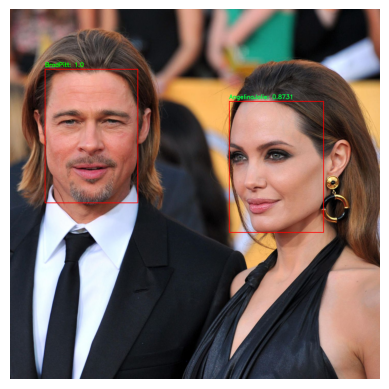

In [11]:
file_name = "brangelina2.jpg"

# is file vid or image? TODO
test_type = h.testsImages
#test_type = h.testsVideos

file_path = test_type + "/" + file_name
file_out = test_type + "/" + f'OUT_{file_name}'

if os.path.isfile(file_path):
    file_extension = os.path.splitext(file_path)[1]
    if file_extension.lower() in {'.mp4'}:
        video_detect(file_path)
    elif file_extension.lower() in {'.jpg', '.jpeg', '.png'}:
        image_detect(file_path)